In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import confusion_matrix

import config

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [2]:
df=pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR+'/data_metabric_table_1.2.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT_ID                           2509 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE        2243 non-null   float64
 2   NPI                                  2287 non-null   float64
 3   COHORT                               2509 non-null   object 
 4   SEX                                  2509 non-null   object 
 5   INTCLUST                             2509 non-null   object 
 6   AGE_AT_DIAGNOSIS                     2498 non-null   float64
 7   OS_MONTHS                            1981 non-null   float64
 8   OS_STATUS                            1981 non-null   object 
 9   CLAUDIN_SUBTYPE                      2509 non-null   object 
 10  THREEGENE                            2509 non-null   object 
 11  VITAL_STATUS                  

In [3]:
target_columns=[
    # patient
    'OS_MONTHS',
    'OS_STATUS',
    'RFS_STATUS',
    'RFS_MONTHS',
    'VITAL_STATUS',
]

int_columns=[
    # patient
    'LYMPH_NODES_EXAMINED_POSITIVE',
]

float_columns=[
    # patient
    'NPI',
    'AGE_AT_DIAGNOSIS',
    # sample
    'TUMOR_SIZE',
    'TMB_NONSYNONYMOUS',
]

str_columns=[
]

# 質的変数（順序尺度）
qualitative_ordinal_columns=[
    # patient
    'CELLULARITY_converted',  
    'ER_IHC_converted',
    'HER2_SNP6_converted',
    'INFERRED_MENOPAUSAL_STATE_converted',
    # sample
    'ER_STATUS_converted',
    'HER2_STATUS_converted',
    'GRADE',
    'PR_STATUS_converted',
    'TUMOR_STAGE',
]
# 質的変数（名義尺度）
qualitative_name_columns=[
    # patient
    'COHORT',
    'INTCLUST',
    'CLAUDIN_SUBTYPE',
    'THREEGENE',
    'HISTOLOGICAL_SUBTYPE',
    'BREAST_SURGERY',
    'LATERALITY',
    # sample
    'CANCER_TYPE',
    'CANCER_TYPE_DETAILED',
    'ONCOTREE_CODE',

]

bool_columns=[
    # patient
    'CHEMOTHERAPY_converted',
    'HORMONE_THERAPY_converted',
    'RADIO_THERAPY_converted',
]

meanless_columns=[
    # patient
    'PATIENT_ID',
    'SEX',
    # sample
    'PATIENT_ID',
    'SAMPLE_ID',
    'SAMPLE_TYPE',
]

print(df.shape[1],
    len(target_columns)+\
    len(int_columns)+\
    len(float_columns)+\
    len(ｓｔｒ_columns)+\
    len(qualitative_ordinal_columns)+\
    len(qualitative_name_columns)+\
    len(bool_columns)+\
    len(meanless_columns))
assert  df.shape[1]==\
    len(target_columns)+\
    len(int_columns)+\
    len(float_columns)+\
    len(ｓｔｒ_columns)+\
    len(qualitative_ordinal_columns)+\
    len(qualitative_name_columns)+\
    len(bool_columns)+\
    len(meanless_columns), 'lack or too much columns'

37 37


## create target column

目的変数：5年以内の死亡判定→5年以内のデータは除外する

In [69]:
df[df['OS_MONTHS']>=60]['VITAL_STATUS']

0                     Living
1                     Living
2            Died of Disease
3                     Living
6                     Living
                ...         
1979         Died of Disease
1980                  Living
1982         Died of Disease
1983    Died of Other Causes
1984    Died of Other Causes
Name: VITAL_STATUS, Length: 1490, dtype: object

In [ ]:
df[df['OS_MONTHS']>=60]['OS_STATUS']

0         0:LIVING
1         0:LIVING
2       1:DECEASED
3         0:LIVING
6         0:LIVING
           ...    
1979    1:DECEASED
1980      0:LIVING
1982    1:DECEASED
1983    1:DECEASED
1984    1:DECEASED
Name: OS_STATUS, Length: 1490, dtype: object

In [72]:
df[df['OS_MONTHS']>=60 and (df['VITAL_STATUS']=='Living' or df['VITAL_STATUS']=='Died of Disease')]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### drop columns & line

In [4]:
def create_drop_columne(target:str, target_columns:list=target_columns, meanless_columns:list=meanless_columns,):
    drop_columns=[i for i in target_columns if i not in [target]]+meanless_columns
    return drop_columns

In [5]:
target='OS_STATUS'
drop_columns=create_drop_columne(target)
df_droped=df.drop(drop_columns, axis=1).dropna().copy()
df.shape, df_droped.shape

((2509, 37), (1293, 28))

In [6]:
df_droped.columns

Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'COHORT', 'INTCLUST',
       'AGE_AT_DIAGNOSIS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE',
       'LATERALITY', 'HISTOLOGICAL_SUBTYPE', 'BREAST_SURGERY',
       'CELLULARITY_converted', 'ER_IHC_converted', 'HER2_SNP6_converted',
       'INFERRED_MENOPAUSAL_STATE_converted', 'CHEMOTHERAPY_converted',
       'HORMONE_THERAPY_converted', 'RADIO_THERAPY_converted', 'CANCER_TYPE',
       'CANCER_TYPE_DETAILED', 'GRADE', 'ONCOTREE_CODE', 'TUMOR_SIZE',
       'TUMOR_STAGE', 'TMB_NONSYNONYMOUS', 'ER_STATUS_converted',
       'HER2_STATUS_converted', 'PR_STATUS_converted'],
      dtype='object')

### onehot encoding
決定木に入れるためにobject型をonehotエンコーディング(nullは削除する)

In [7]:
df_droped.dtypes

LYMPH_NODES_EXAMINED_POSITIVE          float64
NPI                                    float64
COHORT                                  object
INTCLUST                                object
AGE_AT_DIAGNOSIS                       float64
OS_STATUS                               object
CLAUDIN_SUBTYPE                         object
THREEGENE                               object
LATERALITY                              object
HISTOLOGICAL_SUBTYPE                    object
BREAST_SURGERY                          object
CELLULARITY_converted                  float64
ER_IHC_converted                       float64
HER2_SNP6_converted                    float64
INFERRED_MENOPAUSAL_STATE_converted    float64
CHEMOTHERAPY_converted                    bool
HORMONE_THERAPY_converted                 bool
RADIO_THERAPY_converted                   bool
CANCER_TYPE                             object
CANCER_TYPE_DETAILED                    object
GRADE                                  float64
ONCOTREE_CODE

In [8]:
onehot_encoder=OneHotEncoder()
onehot_encoding_columns=qualitative_name_columns
onehot_encoder.fit(df_droped[onehot_encoding_columns])
display(onehot_encoder.categories_)
display(onehot_encoder.get_feature_names_out(onehot_encoding_columns))
#enc.transform(df_droped[encoding_columns]).toarray()
df_onehot=pd.DataFrame(onehot_encoder.transform(df_droped[onehot_encoding_columns]).toarray(), 
             columns=onehot_encoder.get_feature_names_out(onehot_encoding_columns))


[array(['1.0', '2.0', '3.0', '5.0'], dtype=object),
 array(['1', '10', '2', '3', '4ER+', '4ER-', '5', '6', '7', '8', '9'],
       dtype=object),
 array(['Basal', 'Her2', 'LumA', 'LumB', 'NC', 'Normal', 'claudin-low'],
       dtype=object),
 array(['ER+/HER2- High Prolif', 'ER+/HER2- Low Prolif', 'ER-/HER2-',
        'HER2+', 'nan'], dtype=object),
 array(['Ductal/NST', 'Lobular', 'Medullary', 'Mixed', 'Mucinous', 'Other',
        'Tubular/ cribriform', 'nan'], dtype=object),
 array(['BREAST CONSERVING', 'MASTECTOMY', 'nan'], dtype=object),
 array(['Left', 'Right', 'nan'], dtype=object),
 array(['Breast Cancer'], dtype=object),
 array(['Breast', 'Breast Invasive Ductal Carcinoma',
        'Breast Invasive Lobular Carcinoma',
        'Breast Invasive Mixed Mucinous Carcinoma',
        'Breast Mixed Ductal and Lobular Carcinoma',
        'Invasive Breast Carcinoma'], dtype=object),
 array(['BRCA', 'BREAST', 'IDC', 'ILC', 'IMMC', 'MDLC'], dtype=object)]

array(['COHORT_1.0', 'COHORT_2.0', 'COHORT_3.0', 'COHORT_5.0',
       'INTCLUST_1', 'INTCLUST_10', 'INTCLUST_2', 'INTCLUST_3',
       'INTCLUST_4ER+', 'INTCLUST_4ER-', 'INTCLUST_5', 'INTCLUST_6',
       'INTCLUST_7', 'INTCLUST_8', 'INTCLUST_9', 'CLAUDIN_SUBTYPE_Basal',
       'CLAUDIN_SUBTYPE_Her2', 'CLAUDIN_SUBTYPE_LumA',
       'CLAUDIN_SUBTYPE_LumB', 'CLAUDIN_SUBTYPE_NC',
       'CLAUDIN_SUBTYPE_Normal', 'CLAUDIN_SUBTYPE_claudin-low',
       'THREEGENE_ER+/HER2- High Prolif',
       'THREEGENE_ER+/HER2- Low Prolif', 'THREEGENE_ER-/HER2-',
       'THREEGENE_HER2+', 'THREEGENE_nan',
       'HISTOLOGICAL_SUBTYPE_Ductal/NST', 'HISTOLOGICAL_SUBTYPE_Lobular',
       'HISTOLOGICAL_SUBTYPE_Medullary', 'HISTOLOGICAL_SUBTYPE_Mixed',
       'HISTOLOGICAL_SUBTYPE_Mucinous', 'HISTOLOGICAL_SUBTYPE_Other',
       'HISTOLOGICAL_SUBTYPE_Tubular/ cribriform',
       'HISTOLOGICAL_SUBTYPE_nan', 'BREAST_SURGERY_BREAST CONSERVING',
       'BREAST_SURGERY_MASTECTOMY', 'BREAST_SURGERY_nan',
       'LATERA

### Label Encoder


label_encoder=LabelEncoder()
label_encoding_columns=qualitative_name_columns
label_encoder.fit(df_droped[label_encoding_columns])
display(label_encoder.categories_)
display(label_encoder.get_feature_names_out(label_encoding_columns))
#enc.transform(df_droped[encoding_columns]).toarray()
df_onehot=pd.DataFrame(enc.transform(df_droped[onehot_encoding_columns]).toarray(), 
             columns=onehot_encoder.get_feature_names_out(onehot_encoding_columns))


In [9]:
df_encoded=pd.merge(df_droped.reset_index(drop=True), df_onehot.reset_index(drop=True), 
                    left_index=True, right_index=True).drop(onehot_encoding_columns, axis=1)

学習用にデータを分割

In [10]:
y=df_encoded[target]
X=df_encoded.drop(target, axis=1)

In [11]:
y.tail()

1288      0:LIVING
1289    1:DECEASED
1290      0:LIVING
1291    1:DECEASED
1292      0:LIVING
Name: OS_STATUS, dtype: object

In [12]:
X.tail()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,AGE_AT_DIAGNOSIS,CELLULARITY_converted,ER_IHC_converted,HER2_SNP6_converted,INFERRED_MENOPAUSAL_STATE_converted,CHEMOTHERAPY_converted,HORMONE_THERAPY_converted,RADIO_THERAPY_converted,GRADE,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,ER_STATUS_converted,HER2_STATUS_converted,PR_STATUS_converted,COHORT_1.0,COHORT_2.0,COHORT_3.0,COHORT_5.0,INTCLUST_1,INTCLUST_10,INTCLUST_2,INTCLUST_3,...,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,HISTOLOGICAL_SUBTYPE_nan,BREAST_SURGERY_BREAST CONSERVING,BREAST_SURGERY_MASTECTOMY,BREAST_SURGERY_nan,LATERALITY_Left,LATERALITY_Right,LATERALITY_nan,CANCER_TYPE_Breast Cancer,CANCER_TYPE_DETAILED_Breast,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,CANCER_TYPE_DETAILED_Invasive Breast Carcinoma,ONCOTREE_CODE_BRCA,ONCOTREE_CODE_BREAST,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
1288,0.0,2.040,70.65,3.0,1.0,2.0,1.0,False,False,True,1.0,20.0,1.0,11.767659,1.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1289,0.0,4.040,75.62,3.0,-1.0,3.0,1.0,False,False,False,3.0,20.0,1.0,5.230071,-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1290,6.0,5.040,52.84,3.0,1.0,2.0,1.0,True,False,True,2.0,20.0,2.0,6.537589,1.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1291,1.0,5.060,48.59,3.0,-1.0,1.0,-1.0,True,False,True,3.0,30.0,2.0,7.845106,-1.0,-1.0,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1292,0.0,3.044,63.20,3.0,1.0,2.0,1.0,False,False,True,2.0,22.0,2.0,3.922553,1.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
X_train, X_test, y_train, y_test=train_test_split(X,y, train_size=0.7, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((905, 71), (388, 71), (905,), (388,))

In [53]:
accuracies={}

for nodes in range(5,50):
    clf = DecisionTreeClassifier(max_leaf_nodes=nodes)
    clf = clf.fit(X_train, y_train)
    #print(clf.classes_)

    y_pred=clf.predict(X_test)
    # accuracy
    
    accuracy=sum(y_test==y_pred)/y_test.shape[0]
    accuracies[nodes]=accuracy
    print('nodes: ',nodes, 'accuracy: ', accuracy)

nodes:  5 accuracy:  0.6881443298969072
nodes:  6 accuracy:  0.6881443298969072
nodes:  7 accuracy:  0.6778350515463918
nodes:  8 accuracy:  0.6778350515463918
nodes:  9 accuracy:  0.6907216494845361
nodes:  10 accuracy:  0.6829896907216495
nodes:  11 accuracy:  0.6804123711340206
nodes:  12 accuracy:  0.6804123711340206
nodes:  13 accuracy:  0.6881443298969072
nodes:  14 accuracy:  0.6907216494845361
nodes:  15 accuracy:  0.6932989690721649
nodes:  16 accuracy:  0.6907216494845361
nodes:  17 accuracy:  0.6958762886597938
nodes:  18 accuracy:  0.6907216494845361
nodes:  19 accuracy:  0.6958762886597938
nodes:  20 accuracy:  0.6907216494845361
nodes:  21 accuracy:  0.6984536082474226
nodes:  22 accuracy:  0.6958762886597938
nodes:  23 accuracy:  0.6984536082474226
nodes:  24 accuracy:  0.6907216494845361
nodes:  25 accuracy:  0.6829896907216495
nodes:  26 accuracy:  0.6855670103092784
nodes:  27 accuracy:  0.6726804123711341
nodes:  28 accuracy:  0.6649484536082474
nodes:  29 accuracy: 

In [54]:
max(accuracies.values())

0.6984536082474226

In [55]:
clf = DecisionTreeClassifier(max_leaf_nodes=20)
clf = clf.fit(X_train, y_train)
#print(clf.classes_)

y_pred=clf.predict(X_test)
# accuracy

print(sum(y_test==y_pred)/y_test.shape[0])

0.6984536082474226


In [56]:
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=X.columns,
                     class_names= y.unique(),
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())
graph.write_png(config.TREE_DIR+'/2.0-decision_tree_model.png')

True

In [29]:
y_test.value_counts()[0]

209

In [30]:
display(y_test.value_counts())

display('baseline:', y_test.value_counts()/y_test.size)

1:DECEASED    209
0:LIVING      179
Name: OS_STATUS, dtype: int64

'baseline:'

1:DECEASED    0.53866
0:LIVING      0.46134
Name: OS_STATUS, dtype: float64

In [31]:
y_pred=clf.predict(X_test)
# accuracy
sum(y_test==y_pred)/y_test.shape[0]

0.6365979381443299

Text(83.40000000000006, 0.5, 'GroundTruth')

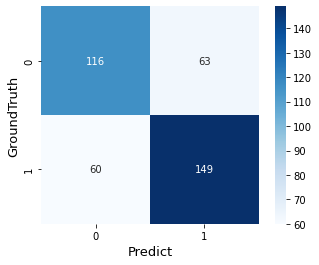

In [21]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='1.0f')
plt.xlabel("Predict", fontsize=13)
plt.ylabel("GroundTruth", fontsize=13)

<AxesSubplot:xlabel='AGE_AT_DIAGNOSIS', ylabel='TMB_NONSYNONYMOUS'>

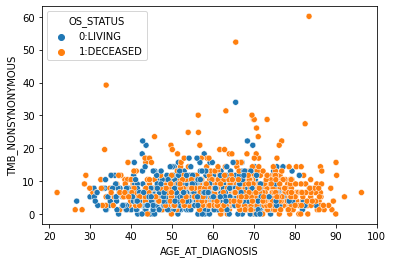

In [20]:
axis_1, axis_2 =X['AGE_AT_DIAGNOSIS'], X['TMB_NONSYNONYMOUS']
sns.scatterplot(x=axis_1, y=axis_2, hue=y, data=X[['AGE_AT_DIAGNOSIS', 'TMB_NONSYNONYMOUS']])